## Dataset load

In [1]:
from simpl_loader import load_simpl_module
simpl = load_simpl_module()

In [2]:
from network_builder import GraphBuilder, SimplicialComplexBuilder, HyperGraphBuilder

In [3]:
import matplotlib.pyplot as plt

In [4]:
from dataset_loader import DatasetLoader

# sets, true_labels = DatasetLoader.load_dataset("contact-high-school")
sets, true_labels = DatasetLoader.load_dataset("house-bills")
# sets, true_labels = DatasetLoader.load_dataset("senate-bills")


In [5]:
# Simplify model of contact dataset on 3 classes -- 123, 459, 678
def compress_labels():
    for i in range(len(true_labels)):
        if true_labels[i] in [1, 2, 3]:
            true_labels[i] = 0
        elif true_labels[i] in [4, 5, 9]:
            true_labels[i] = 1
        elif true_labels[i] in [6, 7, 8]:
            true_labels[i] = 2
        else:
            assert False

    with open("./data/node-compact-labels-contact-high-school.txt", 'w') as f:
        for i in range(len(true_labels)):
            f.write(f"{true_labels[i]+1}\n")
    
# compress_labels()

In [6]:
# labeled_hyper_edges = list(map(lambda row: list(map(lambda x: true_labels[x], row)), sets))

## Dataset info

In [7]:
E = len(sets)
V = len(true_labels)
K = len(set(true_labels))
print(f"Number of edges: {E}")
print(f"Number of vertices: {V}")
print(f"Number of classes: {K}")
num_eig = min(V, 2 * K + 7)

Number of edges: 32337
Number of vertices: 1494
Number of classes: 2


## ML prep

In [8]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
np.random.seed(123)

In [10]:
def solve(X, y, random_state=42) -> float:
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
	scaler = StandardScaler()
	X_train_scaled = scaler.fit_transform(X_train)
	X_test_scaled = scaler.transform(X_test)

	clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=random_state)
	clf.fit(X_train_scaled, y_train)

	y_pred = clf.predict(X_test_scaled).reshape(-1, 1)

	accuracy = accuracy_score(y_test, y_pred)
	return accuracy

def mean_solve(X, y, n_iter=10) -> float:
	results = []
	for it in range(n_iter):
		results.append(solve(X, y, it))
	mean_acc = np.mean(results)
	print(f"Mean accuracy: {mean_acc:.5f}")
	return mean_acc

In [11]:
y = np.array(true_labels)

In [12]:
def iterate_eigenvalues(eigenvectors):
    result = []
    for i in range(1, num_eig+1):
        X = eigenvectors[:, :i]
        result.append(mean_solve(X, y)) 
    return result

## Graph

In [13]:
graph_builder = GraphBuilder(sets, True)
graph = graph_builder.build()
for v in range(V):
    graph.AddEdge(v, v)

In [14]:
graph.FVector()

[(0, 1494), (1, 143656)]

In [15]:
results_graph_unweighted_norm = []
results_graph_weighted_norm = []
results_graph_unweighted = []
results_graph_weighted = []

In [16]:
results_graph_unweighted = iterate_eigenvalues(np.array(graph.EigenValues(0, -1, 1, False, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.54432
Mean accuracy: 0.54878
Mean accuracy: 0.54833
Mean accuracy: 0.55479
Mean accuracy: 0.55568
Mean accuracy: 0.55367
Mean accuracy: 0.55278
Mean accuracy: 0.55479


In [17]:
results_graph_weighted = iterate_eigenvalues(np.array(graph.EigenValues(0, -1, 1, True, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.52695
Mean accuracy: 0.54477
Mean accuracy: 0.54454
Mean accuracy: 0.55278
Mean accuracy: 0.55679
Mean accuracy: 0.56013
Mean accuracy: 0.56236
Mean accuracy: 0.56147
Mean accuracy: 0.57550


In [18]:
results_graph_unweighted_norm = iterate_eigenvalues(np.array(graph.EigenValues(0, -1, 1, False, True, num_eig, 'sm')[1]))

Mean accuracy: 0.55991
Mean accuracy: 0.57171
Mean accuracy: 0.56637
Mean accuracy: 0.84165
Mean accuracy: 0.84566
Mean accuracy: 0.84633
Mean accuracy: 0.84365
Mean accuracy: 0.87105
Mean accuracy: 0.88976
Mean accuracy: 0.89510
Mean accuracy: 0.90134


In [19]:
results_graph_weighted_norm = iterate_eigenvalues(np.array(graph.EigenValues(0, -1, 1, True, True, num_eig, 'sm')[1]))

Mean accuracy: 0.56481
Mean accuracy: 0.58463
Mean accuracy: 0.59109
Mean accuracy: 0.77528
Mean accuracy: 0.77416
Mean accuracy: 0.78218
Mean accuracy: 0.78842
Mean accuracy: 0.79666
Mean accuracy: 0.80379
Mean accuracy: 0.82695
Mean accuracy: 0.82762


In [20]:
clos = np.array([val[1] for val in graph.ClosenessAll(0, 1, True)]).reshape(-1, 1)
betw = np.array([val[1] for val in graph.BetweennessAll(0, 1, True)]).reshape(-1, 1)

In [21]:
mean_solve(clos, y)
mean_solve(betw, y)

Mean accuracy: 0.56726
Mean accuracy: 0.52339


0.5233853006681514

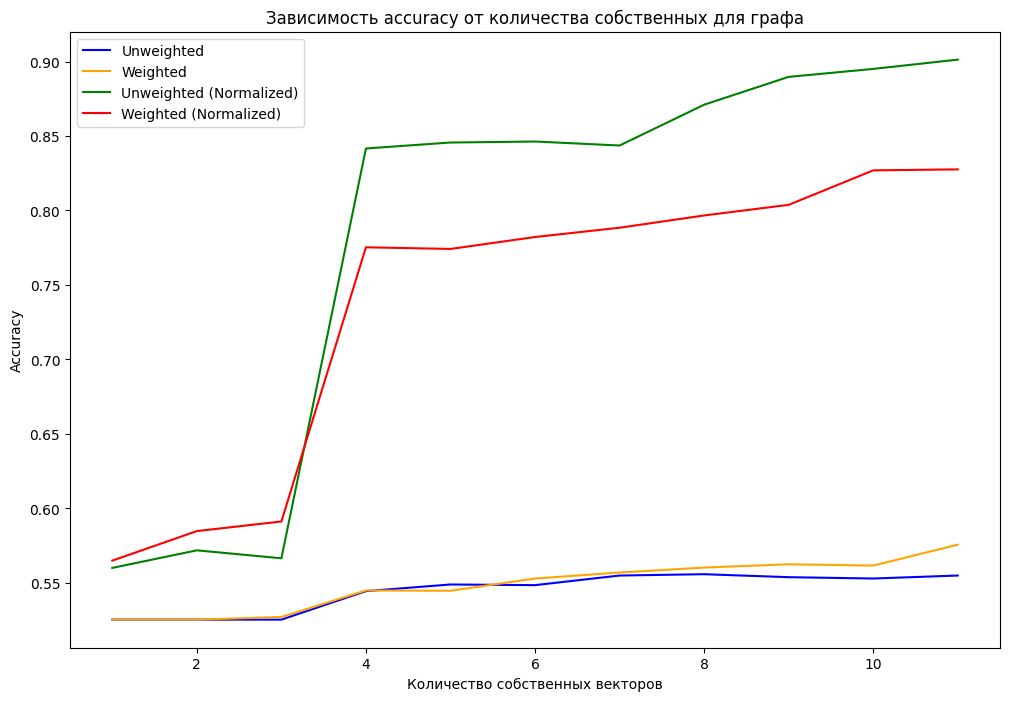

In [22]:
plt.figure(figsize=(12, 8))

iterations = [i for i in range(1, num_eig+1)]
plt.plot(iterations, results_graph_unweighted, label='Unweighted', color='blue')
plt.plot(iterations, results_graph_weighted, label='Weighted', color='orange')
plt.plot(iterations, results_graph_unweighted_norm, label='Unweighted (Normalized)', color='green')
plt.plot(iterations, results_graph_weighted_norm, label='Weighted (Normalized)', color='red')

plt.xlabel('Количество собственных векторов')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от количества собственных для графа')

plt.legend()

plt.show()

### Hypergraph 

In [23]:
hyper_graph_builder = HyperGraphBuilder(sets, True)
hyper_graph = hyper_graph_builder.build()
for v in range(V):
    hyper_graph.AddEdge([v, v])

In [24]:
hyper_graph.FVector()

[(0, 1494), (1, 28521)]

In [25]:
results_hyper_graph_unweighted = []
results_hyper_graph_weighted = []
results_hyper_graph_unweighted_norm = []
results_hyper_graph_weighted_norm = []

In [26]:
results_hyper_graph_unweighted = iterate_eigenvalues(np.array(hyper_graph.EigenValues(0, -1, 1, False, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52584
Mean accuracy: 0.52584
Mean accuracy: 0.52517
Mean accuracy: 0.53073
Mean accuracy: 0.53118
Mean accuracy: 0.53296
Mean accuracy: 0.53252
Mean accuracy: 0.53096
Mean accuracy: 0.53051
Mean accuracy: 0.54232
Mean accuracy: 0.54165


In [27]:
results_hyper_graph_weighted = iterate_eigenvalues(np.array(hyper_graph.EigenValues(0, -1, 1, True, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52428
Mean accuracy: 0.52428
Mean accuracy: 0.52517
Mean accuracy: 0.53029
Mean accuracy: 0.53185
Mean accuracy: 0.53140
Mean accuracy: 0.53051
Mean accuracy: 0.53007
Mean accuracy: 0.53118
Mean accuracy: 0.54098
Mean accuracy: 0.53920


In [28]:
results_hyper_graph_unweighted_norm = iterate_eigenvalues(np.array(hyper_graph.EigenValues(0, -1, 1, False, True, num_eig, 'sm')[1]))

Mean accuracy: 0.54298
Mean accuracy: 0.57372
Mean accuracy: 0.56815
Mean accuracy: 0.56860
Mean accuracy: 0.57171
Mean accuracy: 0.56459
Mean accuracy: 0.57372
Mean accuracy: 0.68976
Mean accuracy: 0.70200
Mean accuracy: 0.72361
Mean accuracy: 0.72004


In [29]:
results_hyper_graph_weighted_norm = iterate_eigenvalues(np.array(hyper_graph.EigenValues(0, -1, 1, True, True, num_eig, 'sm')[1]))

Mean accuracy: 0.54120
Mean accuracy: 0.54944
Mean accuracy: 0.57483
Mean accuracy: 0.56771
Mean accuracy: 0.56325
Mean accuracy: 0.56414
Mean accuracy: 0.56748
Mean accuracy: 0.56971
Mean accuracy: 0.56748
Mean accuracy: 0.56503
Mean accuracy: 0.64076


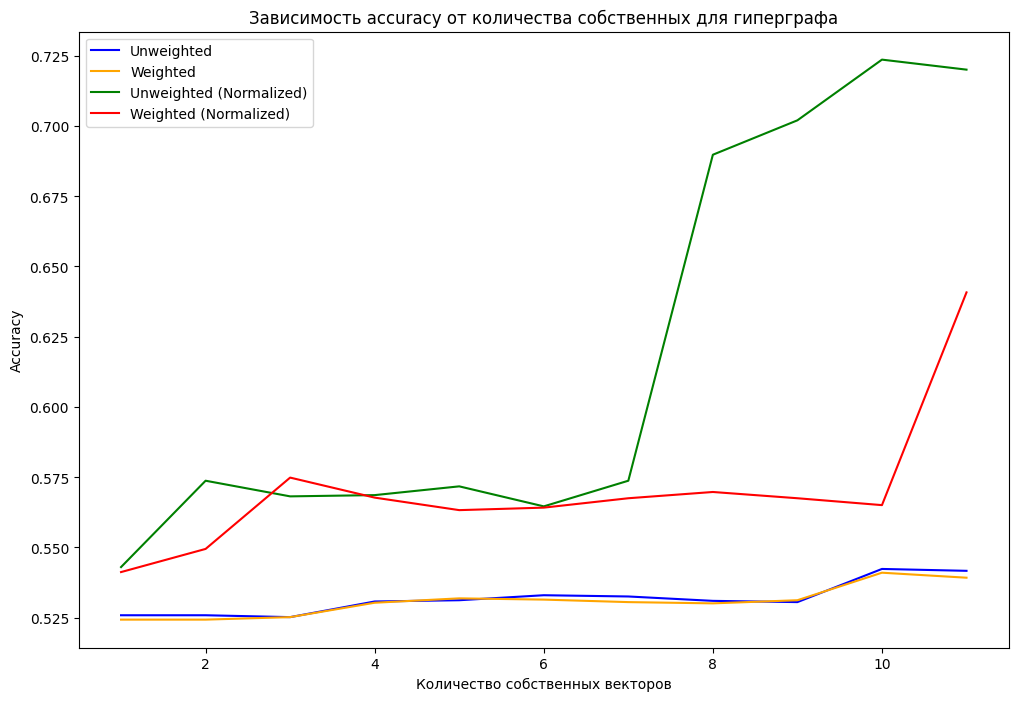

In [30]:
plt.figure(figsize=(12, 8))

iterations = [i for i in range(1, num_eig+1)]
plt.plot(iterations, results_hyper_graph_unweighted, label='Unweighted', color='blue')
plt.plot(iterations, results_hyper_graph_weighted, label='Weighted', color='orange')
plt.plot(iterations, results_hyper_graph_unweighted_norm, label='Unweighted (Normalized)', color='green')
plt.plot(iterations, results_hyper_graph_weighted_norm, label='Weighted (Normalized)', color='red')

plt.xlabel('Количество собственных векторов')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от количества собственных для гиперграфа')

plt.legend()

plt.show()

## Hodge

In [31]:
# eigenvectors = np.array(hyper_graph.EigenValues(0, -1, 1, True, True, num_eig, 'sm')[1])

In [32]:
# eigenvectors.shape

In [ ]:
# eig_decomposition = np.zeros((eigenvectors.shape[0], 0))

# for i in range(eigenvectors.shape[1]):
#     c1, c2, c3 = hyper_graph.HodgeDecomposition(0, -1, 1, list(eigenvectors[:, i]))
    
#     c1 = np.array(c1).reshape(-1, 1)
#     c2 = np.array(c2).reshape(-1, 1)
#     c3 = np.array(c3).reshape(-1, 1)

#     to_add = []
#     for c in [c1, c2, c3]:
#         if np.isfinite(c).all() and not np.all(c == c[0]):
#             to_add.append(c)

#     if len(to_add) > 0:
#         eig_decomposition = np.hstack((eig_decomposition, *to_add))

#     X = np.asarray(eig_decomposition)
#     mean_solve(X, y)


In [34]:
# eig_decomposition = np.asarray(eig_decomposition)

In [35]:
# result = []
# for i in range(3, 6 * K, +3):
# 	X = eig_decomposition[:, :i]
# 	result.append(mean_solve(X, y)) 


## Simplicial complex

In [36]:
simplicial_complex_builder = SimplicialComplexBuilder(sets)
simpl_complex = simplicial_complex_builder.build()
for v in range(V):
    simpl_complex.AddSimplex([v, v])

In [37]:
simpl_complex.FVector()

[(0, 1494),
 (1, 143656),
 (2, 488866),
 (3, 709390),
 (4, 705113),
 (5, 499376),
 (6, 247909),
 (7, 82185),
 (8, 16371),
 (9, 1484)]

In [38]:
results_simpl_complex_unweighted = []
results_simpl_complex_weighted = []
results_simpl_complex_unweighted_norm = []
results_simpl_complex_weighted_norm = []

In [39]:
results_simpl_complex_unweighted = iterate_eigenvalues(np.array(simpl_complex.EigenValues(0, -1, 1, False, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.54432
Mean accuracy: 0.54878
Mean accuracy: 0.54833
Mean accuracy: 0.55479
Mean accuracy: 0.55568
Mean accuracy: 0.55367
Mean accuracy: 0.55278
Mean accuracy: 0.55479


In [40]:
results_simpl_complex_weighted = iterate_eigenvalues(np.array(simpl_complex.EigenValues(0, -1, 1, True, False, num_eig, 'sm')[1]))

Mean accuracy: 0.52517
Mean accuracy: 0.52517
Mean accuracy: 0.52695
Mean accuracy: 0.54477
Mean accuracy: 0.54454
Mean accuracy: 0.55278
Mean accuracy: 0.55679
Mean accuracy: 0.56013
Mean accuracy: 0.56236
Mean accuracy: 0.56147
Mean accuracy: 0.57550


In [41]:
results_simpl_complex_unweighted_norm = iterate_eigenvalues(np.array(simpl_complex.EigenValues(0, -1, 1, False, True, num_eig, 'sm')[1]))

Mean accuracy: 0.55991
Mean accuracy: 0.57171
Mean accuracy: 0.56637
Mean accuracy: 0.84165
Mean accuracy: 0.84566
Mean accuracy: 0.84633
Mean accuracy: 0.84365
Mean accuracy: 0.87105
Mean accuracy: 0.88976
Mean accuracy: 0.89510
Mean accuracy: 0.90134


In [42]:
results_simpl_complex_weighted_norm = iterate_eigenvalues(np.array(simpl_complex.EigenValues(0, -1, 1, True, True, num_eig, 'sm')[1]))

Mean accuracy: 0.56481
Mean accuracy: 0.58463
Mean accuracy: 0.59109
Mean accuracy: 0.77528
Mean accuracy: 0.77416
Mean accuracy: 0.78218
Mean accuracy: 0.78842
Mean accuracy: 0.79666
Mean accuracy: 0.80379
Mean accuracy: 0.82695
Mean accuracy: 0.82762


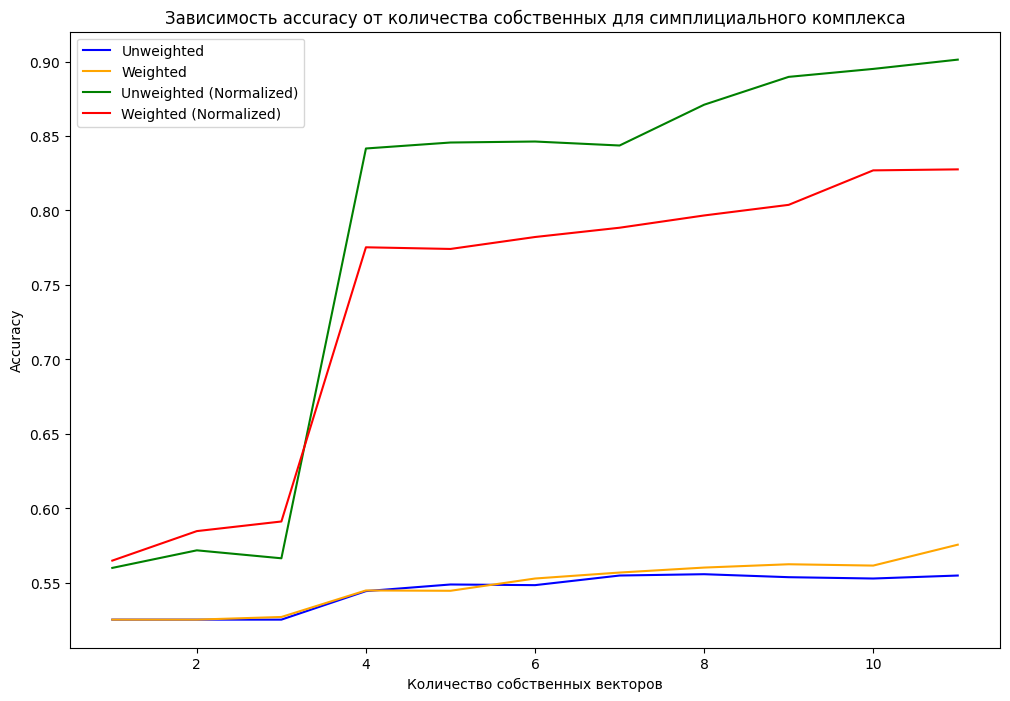

In [43]:
plt.figure(figsize=(12, 8))

iterations = [i for i in range(1, num_eig+1)]
plt.plot(iterations, results_simpl_complex_unweighted, label='Unweighted', color='blue')
plt.plot(iterations, results_simpl_complex_weighted, label='Weighted', color='orange')
plt.plot(iterations, results_simpl_complex_unweighted_norm, label='Unweighted (Normalized)', color='green')
plt.plot(iterations, results_simpl_complex_weighted_norm, label='Weighted (Normalized)', color='red')

plt.xlabel('Количество собственных векторов')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от количества собственных для симплициального комплекса')

plt.legend()

plt.show()

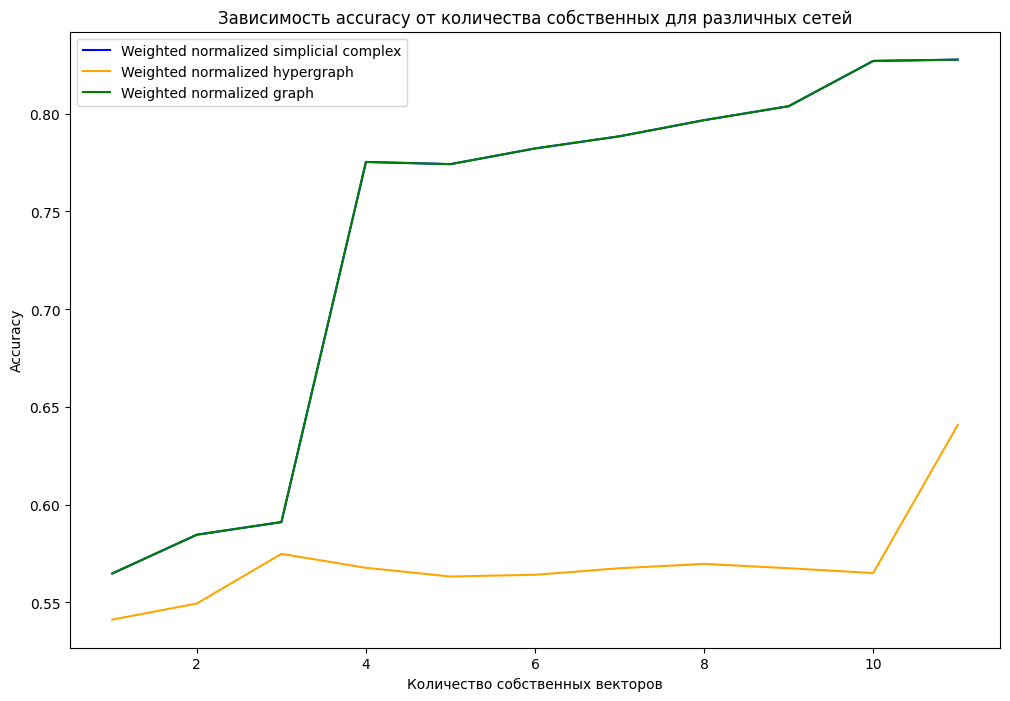

In [44]:
plt.figure(figsize=(12, 8))

iterations = [i for i in range(1, num_eig+1)]
plt.plot(iterations, results_simpl_complex_weighted_norm, label='Weighted normalized simplicial complex', color='blue')
plt.plot(iterations, results_hyper_graph_weighted_norm, label='Weighted normalized hypergraph', color='orange')
plt.plot(iterations, results_graph_weighted_norm, label='Weighted normalized graph', color='green')

plt.xlabel('Количество собственных векторов')
plt.ylabel('Accuracy')
plt.title('Зависимость accuracy от количества собственных для различных сетей')

plt.legend()

plt.show()

In [45]:
clos1 = simpl_complex.ClosenessAll(0, 1, True)
clos1 = np.array([value for _, value in clos1])
betw1 = simpl_complex.BetweennessAll(0, 1, True)
betw1 = np.array([value for _, value in betw1])

In [46]:
clos2 = simpl_complex.ClosenessAll(0, 2, True)
clos2 = np.array([value for _, value in clos2])
betw2 = simpl_complex.BetweennessAll(0, 2, True)
betw2 = np.array([value for _, value in betw2])

In [47]:
X = np.zeros(clos1.shape).reshape(-1, 1)

In [48]:
X.shape

(1494, 1)

In [49]:
# X = np.hstack((betw1.reshape(-1, 1), clos1.reshape(-1, 1)))
# X = np.hstack((X, betw2.reshape(-1, 1), clos2.reshape(-1, 1)))
solve(X, y)

0.5033407572383074